In [1]:
import torch
from torch.optim.lr_scheduler import StepLR
#
from matplotlib import pyplot as plt
import numpy as np
from time import time

In [21]:
print('torch version:',torch.__version__)

torch version: 1.13.1


\begin{equation}
\begin{array}{r@{}ll}
u_{tt} -  c^2u_{xx} &= 0,& (-L,L)\times (0,T] \\
u(x,0) &= \exp\left(- A\left(x - x_0\right)^2\right), & (0,L)\times \{0\} \\
u_{t}(r,0) & = 0,  & (0,L)\times \{0\} \\
%\phi_t - \frac{\phi}{r} + \phi_r  &= 0,& \{L\}\times (0,T)
\end{array}
\end{equation}

In [2]:
L     = 40
T     = 30
x0    = 0
A     = 1.
c = 1.

$$u(x,t) = \frac{1}{2}\exp\left(-A(x - x_0 -ct)^2\right) + \frac{1}{2}\exp\left(-A(x - x_0 +ct)^2\right)$$

In [3]:
def exact_sol_f(x,t,x0=x0,A=A,c=c):
    aux = torch.exp(-A*((x - x0) - c*t)**2)/2 + torch.exp(-A*((x - x0) + c*t)**2)/2
    return aux

In [4]:
epochs_list = [6000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,20000]
gamma1 = 100.
gamma2 = 100.
#
dom_points = 1024
bc_points  = 64
ic_points  = 32

In [5]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model,self).__init__()
        self.layer01 = torch.nn.Linear(2,10)
        self.layer02 = torch.nn.Linear(10,50)
        self.layer03 = torch.nn.Linear(50,50)
        self.layer04 = torch.nn.Linear(50,50)
        self.layer05 = torch.nn.Linear(50,10)
        self.layer06 = torch.nn.Linear(10,1)
    
    def forward(self,x,t):
        inputs      = torch.cat([x,t], axis=1)
        out_layer01 = torch.tanh(self.layer01(inputs))
        out_layer02 = torch.tanh(self.layer02(out_layer01))
        out_layer03 = torch.tanh(self.layer03(out_layer02))
        out_layer04 = torch.tanh(self.layer04(out_layer03))
        out_layer05 = torch.tanh(self.layer05(out_layer04))
        out_layer06 = self.layer06(out_layer05)
        output      = out_layer06
        return output

In [6]:
def loss_1(r,t):
    u = model(r,t)
    # Derivatives
    u_t  = torch.autograd.grad(outputs=u, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_tt = torch.autograd.grad(outputs=u_t, 
                              inputs=t,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u_t)
                              )[0]
    u_r  = torch.autograd.grad(outputs=u, 
                              inputs=r,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u)
                              )[0]
    u_rr = torch.autograd.grad(outputs=u_r, 
                               inputs=r,
                               create_graph=True,
                               grad_outputs=torch.ones_like(u_r)
                               )[0]
    #
    #residual = u_tt - 2*u_r/r - u_rr
    residual = u_tt - (c**2)*u_rr
    loss_dom = torch.mean(torch.pow(residual,2))
    return loss_dom

#def loss_2(r_bc,t_bc):
#    u_bc    = model(r_bc,t_bc)
#    #
#    u_bc_t  = torch.autograd.grad(outputs=u_bc, 
#                              inputs=t_bc,
#                              create_graph=True,
#                              grad_outputs=torch.ones_like(u_bc)
#                              )[0]
#    u_bc_r  = torch.autograd.grad(outputs=u_bc, 
#                              inputs=r_bc,
#                              create_graph=True,
#                              grad_outputs=torch.ones_like(u_bc)
#                              )[0]
#    #
#    loss_bc = torch.mean(torch.pow(r_bc*u_bc_t - u_bc + r_bc*u_bc_r,2))
#    return loss_bc

def loss_3(r_ic,t_ic):
    u_ic     = model(r_ic,t_ic)
    #
    u_ic_t   = torch.autograd.grad(outputs=u_ic, 
                              inputs=t_ic,
                              create_graph=True,
                              grad_outputs=torch.ones_like(u_ic)
                              )[0]
    #
    loss_ic  = torch.mean(torch.pow(u_ic - torch.exp(-A*torch.pow((r_ic),2)),2))
    loss_ic += torch.mean(torch.pow(u_ic_t - 0.,2))
    return loss_ic

In [7]:
def random_domain_points(b,T,n=8192):
    x = (2*b)*(torch.rand(n,1,requires_grad=True) - 0.5)
    t = T*torch.rand(n,1,requires_grad=True)
    #x2 = torch.rand(600,1,requires_grad=True)/100
    #t2 = T*torch.rand(600,1,requires_grad=True)
    #x  = torch.cat((x1,x2),0)
    #t  = torch.cat((t1,t2),0)
    return x,t
def random_BC_points(b,T,n=512):
    x = (2*b)*(torch.ones((n,1),dtype=torch.float32,requires_grad=True) - 0.5)
    t = T*torch.rand(n,1,requires_grad=True)
    return x,t
def random_IC_points(b,n=128):
    x = (2*b)*(torch.rand(n,1,requires_grad=True) - 0.5)
    t = torch.zeros(n,1,requires_grad=True)
    return x,t

In [8]:
torch.manual_seed(42)
model = Model()

In [9]:
optimizer = torch.optim.Adam(model.parameters(),
                              lr=0.0005)
scheduler = StepLR(optimizer, step_size=2000, gamma=1., verbose=False)  # Learning rate scheduler

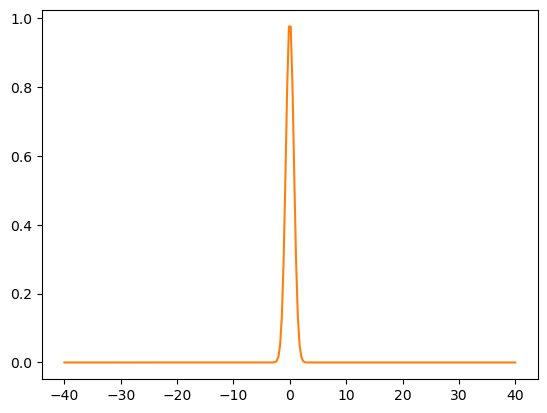

In [10]:
x = torch.linspace(-L,L,256).view(-1,1)
#
plt.figure()
exact_sol = exact_sol_f(x,0.)
plt.plot(x,exact_sol,label='exact sol',color='tab:orange')

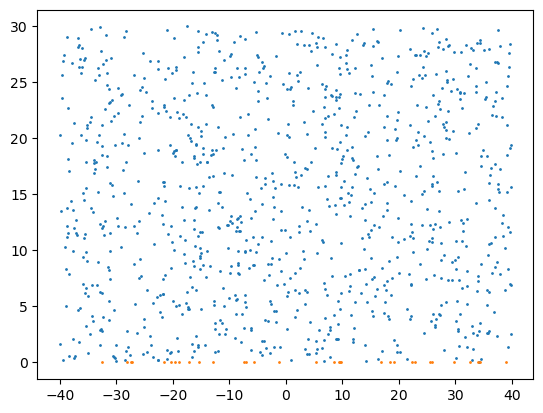

In [11]:
r,t        = random_domain_points(L,T,n=dom_points)
#r_bc, t_bc = random_BC_points(L,T,n=bc_points)
r_ic, t_ic = random_IC_points(L,n=ic_points)
plt.plot(r.detach().numpy(),t.detach().numpy(),'o',ms=1)
#plt.plot(r_bc.detach().numpy(),t_bc.detach().numpy(),'o')
plt.plot(r_ic.detach().numpy(),t_ic.detach().numpy(),'o',ms=1)
plt.show()

In [12]:
loss_list = []
t0 = time()
# Initial training set

for epochs in epochs_list:
    for epoch in range(int(epochs)):
        # Track epochs
        #if (epoch%(epochs/10)==0):
        #    print('epoch:',epoch)
        optimizer.zero_grad() # to make the gradients zero
        # RESIDUAL ################################################################   
        loss_dom = loss_1(r,t)
        # BC ######################################################################
        #loss_bc  =  loss_2(r_bc,t_bc)
        # IC ######################################################################
        loss_ic  = loss_3(r_ic,t_ic)
        # LOSS ####################################################################
        loss = loss_dom + gamma2*loss_ic
        loss_list.append(loss.detach().numpy())
        loss.backward(retain_graph=True) # This is for computing gradients using backward propagation
        optimizer.step() # 
        scheduler.step()  # Update learning rate
        if epoch % 1000 == 0:
            print(f"Epoch: {epoch} - Loss: {loss.item():>7f} - Learning Rate: {scheduler.get_last_lr()[0]:>7f}")
    # Adative sample step    
    r_,t_        = random_domain_points(L,T,n=10*dom_points)
    loss_dom_aux = torch.zeros_like(r_)
    #
    #r_bc_, t_bc_ = random_BC_points(L,T,n=bc_points)
    #loss_bc_aux  = torch.zeros_like(r_bc_)
    #
    r_ic_, t_ic_ = random_IC_points(L,n=10*ic_points)
    loss_ic_aux = torch.zeros_like(r_ic_)
    #
    for idx in range(r_.shape[0]):
        loss_dom_aux[idx] = loss_1(r_[idx:idx+1],t_[idx:idx+1])
    #for idx in range(r_bc_.shape[0]):
    #    loss_bc_aux[idx] = loss_2(r_bc_[idx:idx+1],t_bc_[idx:idx+1])
    for idx in range(r_ic_.shape[0]):
        loss_ic_aux[idx] = loss_3(r_ic_[idx:idx+1],t_ic_[idx:idx+1])    
    #
    idx_dom = torch.where(loss_dom_aux >= loss_dom_aux.sort(0)[0][-500])
    #idx_bc  = torch.where(loss_bc_aux >= loss_bc_aux.sort(0)[0][-10])
    idx_ic  = torch.where(loss_ic_aux >= loss_ic_aux.sort(0)[0][-50])
    #
    r_aux = r_[idx_dom].view(-1,1)
    #print(r_[idx_dom])
    t_aux = t_[idx_dom].view(-1,1)
    r = torch.cat((r,r_aux),0)
    t = torch.cat((t,t_aux),0)
    #
    #r_bc_aux = r_bc_[idx_bc].view(-1,1)
    #t_bc_aux = t_bc_[idx_bc].view(-1,1)
    #r_bc = torch.cat((r_bc,r_bc_aux),0)
    #t_bc = torch.cat((t_bc,t_bc_aux),0)
    #
    r_ic_aux = r_ic_[idx_ic].view(-1,1)
    t_ic_aux = t_ic_[idx_ic].view(-1,1)
    r_ic = torch.cat((r_ic,r_ic_aux),0)
    t_ic = torch.cat((t_ic,t_ic_aux),0)
    #
    # keep editing from here (code the criteria to select the point with biggest loss value)
    #
print('computing time',(time() - t0)/60,'[min]')  

Epoch: 0 - Loss: 5.021472 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.000245 - Learning Rate: 0.000500
Epoch: 2000 - Loss: 0.000084 - Learning Rate: 0.000500
Epoch: 3000 - Loss: 0.000280 - Learning Rate: 0.000500
Epoch: 4000 - Loss: 0.000047 - Learning Rate: 0.000500
Epoch: 5000 - Loss: 0.000041 - Learning Rate: 0.000500
Epoch: 0 - Loss: 2.968524 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.006695 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.005939 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.002379 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.002137 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.001467 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.001411 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.001109 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.002073 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.000822 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.000744 - Learning Rate: 0.000500
Epoch: 1000 - Loss: 0.000644 - Learning Rate: 0.000500
Epoch: 0 - Loss: 0.000432 - Lea

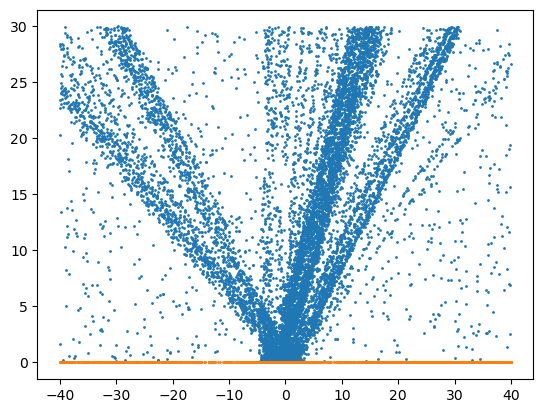

In [13]:
plt.plot(r.detach().numpy(),t.detach().numpy(),'o',ms=1)
#plt.plot(r_bc.detach().numpy(),t_bc.detach().numpy(),'o')
plt.plot(r_ic.detach().numpy(),t_ic.detach().numpy(),'o',ms=1)
plt.show()

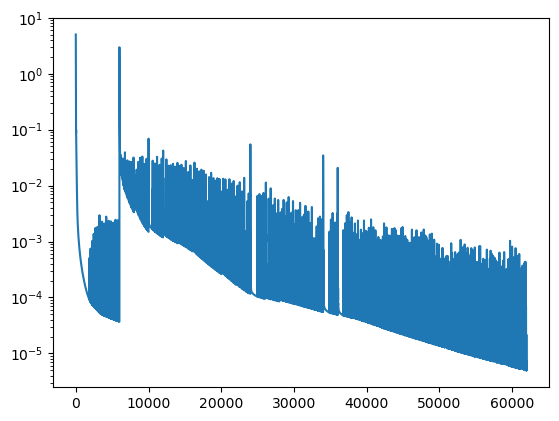

In [14]:
plt.semilogy(loss_list)

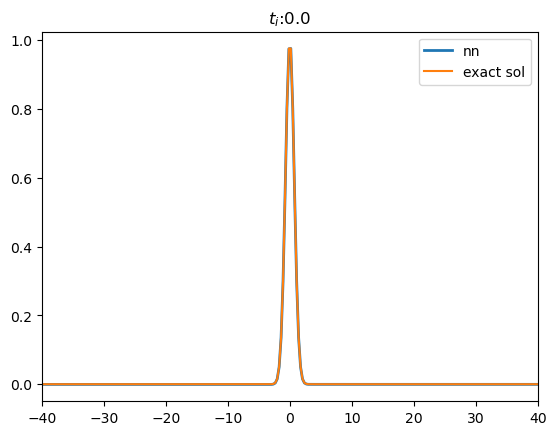

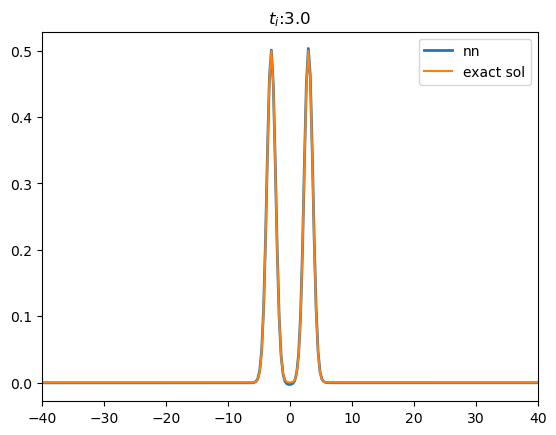

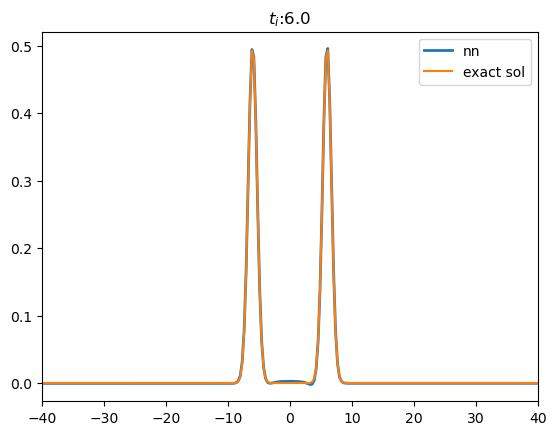

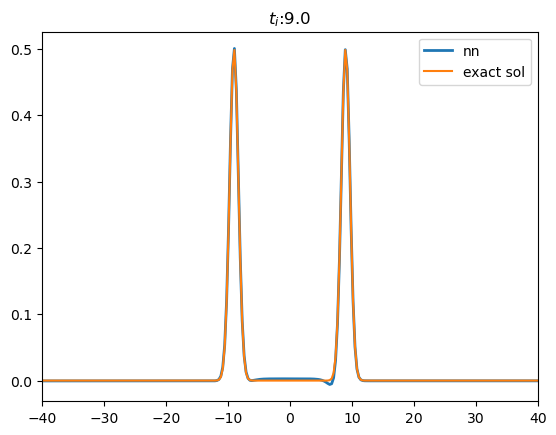

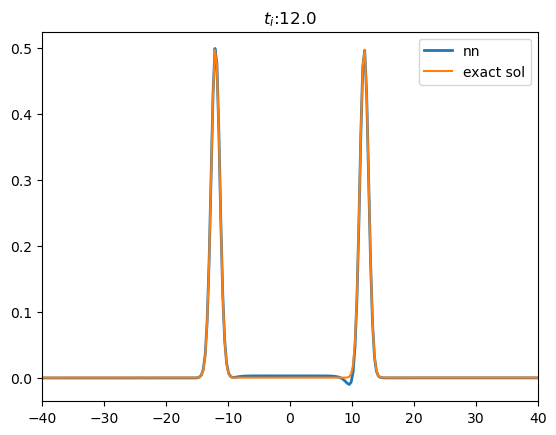

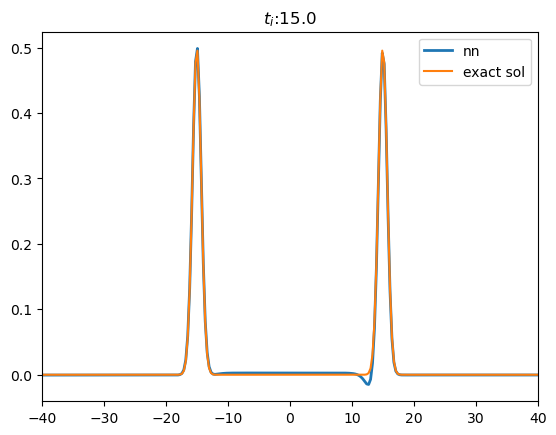

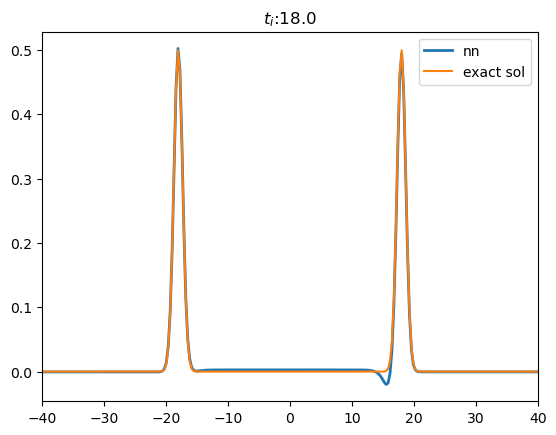

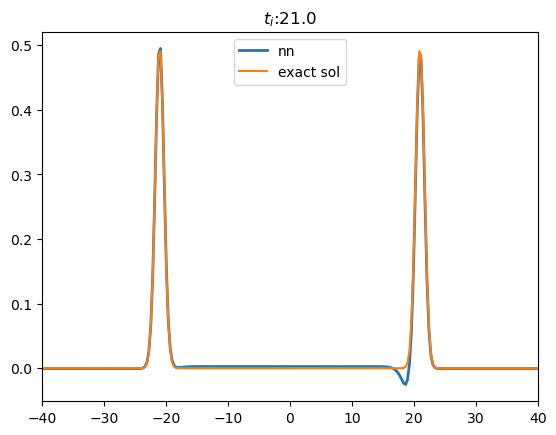

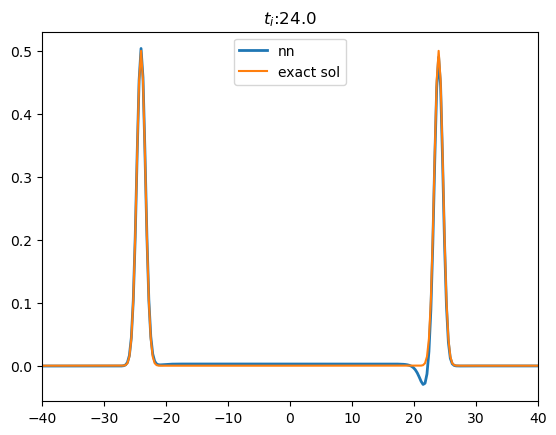

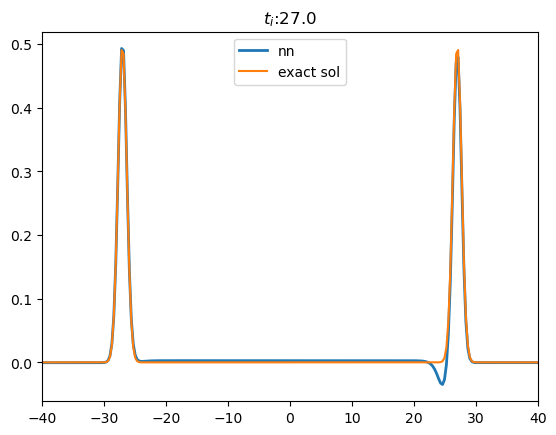

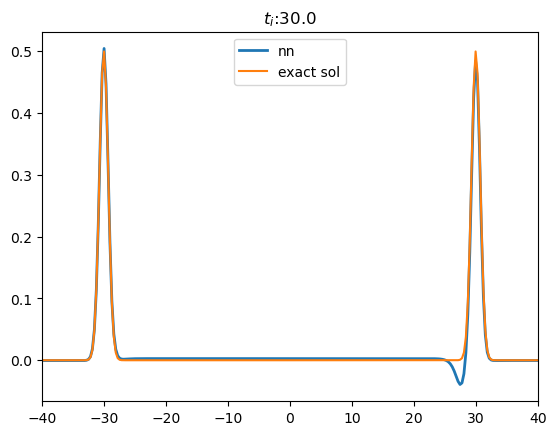

In [15]:
for t_i in np.linspace(0,T,11):
    t = t_i*torch.ones_like(x)
    nn_sol = model(x,t).detach().numpy()
    #
    plt.figure()
    plt.plot(x,nn_sol,label='nn',linewidth='2')
    exact_sol = exact_sol_f(x,t_i)
    plt.plot(x,exact_sol,color='tab:orange',label='exact sol')
    plt.title(r'$t_i$:'+str(t_i))
    plt.xlim(-L,L)
    plt.legend()
    
    #label = 'wave_eq_data_'+str(t_i)+'.txt'
    #with open(label,'w') as f:
    #    for j in range(nn_sol.shape[0]):
    #        f.write(str(x[j].numpy()[0])+' '+str(nn_sol[j][0]))
    #        f.write('\n')

In [16]:
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

C:\Users\ignac\AppData\Local\Temp\ipykernel_32364\753016820.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


MovieWriter imagemagick unavailable; using Pillow instead.


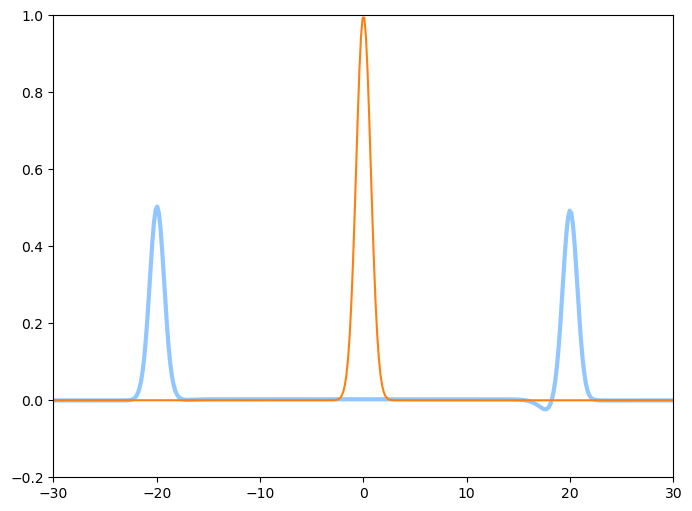

In [17]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(xlim=(-L+10, L-10), ylim=(-.2, 1.))
line, = ax.plot([], [], lw=3)

x = np.linspace(-L,L,512)
y = A*np.exp(-(A*(x)**2))
#
plt.plot(x,y,color='tab:orange',label='initial condition')

def init():
    #
    line.set_data([], [])
    return line,
def animate(i):
    x = torch.linspace(-L,L,512).view(-1,1)
    #
    t = 0.01*i*torch.ones_like(x)
    y = model(x,t).detach().numpy()
    #
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=2000, interval=30, blit=True)


anim.save('cartesian_wave_eq_adaptive_sampling_new.gif', writer='imagemagick')